In [1]:
from flask import Flask, request, redirect, url_for,send_from_directory, render_template_string
from werkzeug.utils import secure_filename
import caffe
import json
import numpy as np
import os
from sklearn import svm,metrics
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import struct
import pandas as pd
from __future__ import division
import collections

In [2]:
deployPrototxt = "/opt/swm-ml-docker/swm-ml-master/bvlc_reference_caffenet/deploy.prototxt"
caffeModel = "/opt/swm-ml-docker/swm-ml-master/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel"
featureVectorDirectory = "/opt/swm-ml-docker/data/train"
metadataDirectory = '/opt/swm-ml-docker/metadata_bak/'
imageMeanFile = '/opt/swm-ml-docker/ilsvrc_2012_mean.npy'
layerName = 'fc7'

In [3]:
print("Loading model ...")
cnn = caffe.Net(deployPrototxt, caffe.TEST, weights=caffeModel)
print("Done loading")

Loading model ...
Done loading


In [4]:
# reshape to accept one image at a time.
(_, c, w, h) = cnn.blobs['data'].data.shape
cnn.blobs['data'].reshape(1, c, w, h)
transformer = caffe.io.Transformer({'data': cnn.blobs['data'].data.shape})
transformer.set_mean('data', np.load(imageMeanFile).mean(1).mean(1))
transformer.set_transpose('data', (2,0,1))
transformer.set_raw_scale('data', 255.0)

In [21]:
def loadMetaData(metadataDir):
    metadataByImageHash = {}
    allFiles = os.listdir(metadataDir)
    for fileName in allFiles:
        with open("%s/%s" % (metadataDir, fileName), "r") as jsonFile:
            metadata = json.load(jsonFile)
            metadataByImageHash[metadata['Image Hash']] = metadata
    return metadataByImageHash

classIdByLabel = {"Dry" : 0, "Wet" : 1, "Reject" : 2, "Garden" : 3}

def makePrimaryLabels(metadataByImageHash, allImageHashes):
    labels = []
    for imageHash in allImageHashes:
        metadata = metadataByImageHash[imageHash]
        labels.append(classIdByLabel[metadata['Primary']])
    return labels

def makeBinaryLabels(metadataByImageHash, allImageHashes):
    labels = []
    for imageHash in allImageHashes:
        metadata = metadataByImageHash[imageHash]
        labels.append(1 if (metadata['Secondary'] == "NA") else 0)
    return labels

def makeBinaryLabelsDict(metadataByImageHash, allImageHashes):
    hashToLabels={}
    for imageHash in allImageHashes:
        metadata = metadataByImageHash[imageHash]
        hashToLabels[imageHash]=(1 if (metadata['Secondary'] == "NA") else 0)
    return hashToLabels
    

In [26]:
metadataByImageHash = loadMetaData(metadataDirectory)
allImageHashes = os.listdir(featureVectorDirectory)
primarylabels = makePrimaryLabels(metadataByImageHash, allImageHashes)
binarylabels= makeBinaryLabels(metadataByImageHash, allImageHashes)
hashtoBinaryLabelsDict=makeBinaryLabelsDict(metadataByImageHash, allImageHashes)
counter=collections.Counter(binarylabels)
print counter[1]

1311


In [45]:
def loadFeatureVectors(dirPath,numImages,hashtoBinaryLabelsDict,label,d):
    allFiles = os.listdir(dirPath)
    imageHash=[]
    data = np.zeros([numImages, d])
    itr=0
    for i, fileName in enumerate(allFiles):
        with open("%s/%s" % (dirPath, fileName), "rb") as inputFile:
            if hashtoBinaryLabelsDict[fileName]==label:
                data[itr] = struct.unpack('f'*d, inputFile.read())
                itr+=1
                imageHash.append(fileName)
    return (data,imageHash)

In [46]:
data,segImageHash=loadFeatureVectors(featureVectorDirectory,counter[1],hashtoBinaryLabelsDict,1, d = 4096)
dataTest,nonsegImageHash=loadFeatureVectors(featureVectorDirectory,counter[0],hashtoBinaryLabelsDict,0, d = 4096)

In [40]:
print (len(data),len(dataTest))

(1311, 871)


In [52]:
segPrimarylabels = makePrimaryLabels(metadataByImageHash, segImageHash)
nonsegPrimarylabels= makePrimaryLabels(metadataByImageHash,nonsegImageHash)
print("Training SVM")
clf = svm.SVC(probability=True)
clf.fit(data, segPrimarylabels)
print("Finished training ready to classify images")

Training SVM
Finished training ready to classify images


In [56]:
prediction_proba=clf.predict_proba(dataTest)
prediction=clf.predict(dataTest)

In [57]:
print prediction_proba

[[  9.13540340e-02   7.96279483e-01   2.35758592e-03   1.10008897e-01]
 [  9.96589361e-01   3.03689180e-03   1.02296425e-04   2.71451091e-04]
 [  1.66853327e-01   8.12708618e-01   2.05739511e-03   1.83806605e-02]
 ..., 
 [  9.64199302e-01   3.32366318e-02   4.69609344e-04   2.09445708e-03]
 [  9.29596661e-01   6.27871802e-02   5.29165640e-04   7.08699330e-03]
 [  4.42515308e-01   5.40390401e-01   5.63806799e-03   1.14562229e-02]]


In [59]:
CM = metrics.confusion_matrix(nonsegPrimarylabels,prediction)
print CM

[[405 117   0   0]
 [ 97 209   0   0]
 [  9   2   0   0]
 [  2  30   0   0]]


In [78]:
maxProba=[]
for i,p in enumerate(prediction_proba):
    maxProba.append(p[nonsegPrimarylabels[i]])
    

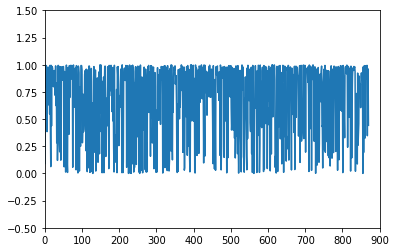

In [86]:
fig = plt.figure()
idx=list(range(871))
plt.axis([0, 900, -0.5, 1.5])
plt.plot(idx,maxProba)
plt.show()


In [91]:
print np.mean(maxProba),np.var(maxProba)

0.670561165277 0.117747671309


In [90]:
cutoff=0.8
count=0
for i in maxProba:
    if i<cutoff:
        count+=1
print count/len(maxProba)
    

0.46383467279


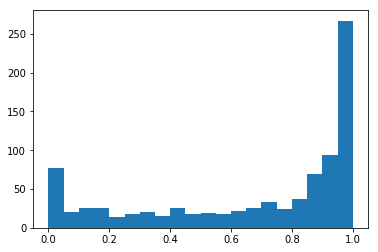

In [92]:
plt.hist(maxProba,20)
plt.show()